# Faster–RCNN

In [9]:
import os
import random
import imageio

image_dir = '/content/breast-tumor-detection/Data/Original_Data/pos'
images = os.listdir(image_dir)
select_images = random.choices(images, k = 309)
random.shuffle(select_images)
training_images = select_images[:30]
validation_images = select_images[30:]
#store training and validation images
train_destination_dir = '/workspaces/breast-tumor-detection/Model/FasterRCNN/data/train'
val_destination_dir = '/workspaces/breast-tumor-detection/Model/FasterRCNN/data/val'

#iterate to store
for img_path in training_images:
    img_path_full = os.path.join(image_dir, img_path)
    assert os.path.exists(img_path_full)
    img = imageio.v2.imread(img_path_full)
    imageio.imwrite(os.path.join(train_destination_dir, img_path), img)
#iterate to store
for img_path in validation_images:
    img_path_full = os.path.join(image_dir, img_path)
    assert os.path.exists(img_path_full)
    img = imageio.v2.imread(img_path_full)
    imageio.imwrite(os.path.join(val_destination_dir, img_path), img)

In [1]:
import sys
sys.path.insert(0,'/workspaces/breast-tumor-detection/Model/FasterRCNN/src/')

In [2]:
from config import DEVICE, NUM_CLASSES, NUM_EPOCHS, OUT_DIR
from config import VISUALIZE_TRANSFORMED_IMAGES
from config import SAVE_PLOTS_EPOCH, SAVE_MODEL_EPOCH
from model import create_model
from utils import Averager, show_tranformed_image
from tqdm.auto import tqdm
from dataset import train_loader, valid_loader
from engine import train, validate
import torch
import matplotlib.pyplot as plt
import time

/workspaces/breast-tumor-detection/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of training samples: 29
Number of validation samples: 10



In [3]:
model = create_model(num_classes=NUM_CLASSES)
model

/workspaces/breast-tumor-detection/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/workspaces/breast-tumor-detection/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]
# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1
# train and validation loss lists to store loss values of all...
# ... iterations till ena and plot graphs for all iterations
train_loss_list = []
val_loss_list = []

# name to save the trained model with
MODEL_NAME = "model"

# whether to show transformed images from data loader or not
if VISUALIZE_TRANSFORMED_IMAGES:
    show_tranformed_image(train_loader)

# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()

    # create two subplots, one for each, training and validation
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    # start timer and carry out training and validation
    start = time.time()
    train_loss = train(train_loader, model, optimizer)
    val_loss = validate(valid_loader, model)
    print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

    if (epoch + 1) % SAVE_MODEL_EPOCH == 0:  # save model after every n epochs
        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
        print("SAVING MODEL COMPLETE...\n")

    if (epoch + 1) % SAVE_PLOTS_EPOCH == 0:  # save loss plots after n epochs
        train_ax.plot(train_loss, color="blue")
        train_ax.set_xlabel("iterations")
        train_ax.set_ylabel("train loss")
        valid_ax.plot(val_loss, color="red")
        valid_ax.set_xlabel("iterations")
        valid_ax.set_ylabel("validation loss")
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
        print("SAVING PLOTS COMPLETE...")

    if (epoch + 1) == NUM_EPOCHS:  # save loss plots and model once at the end
        train_ax.plot(train_loss, color="blue")
        train_ax.set_xlabel("iterations")
        train_ax.set_ylabel("train loss")
        valid_ax.plot(val_loss, color="red")
        valid_ax.set_xlabel("iterations")
        valid_ax.set_ylabel("validation loss")
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")

        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")

Number of training images: 29


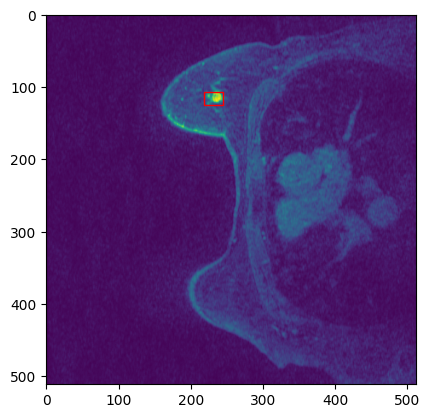

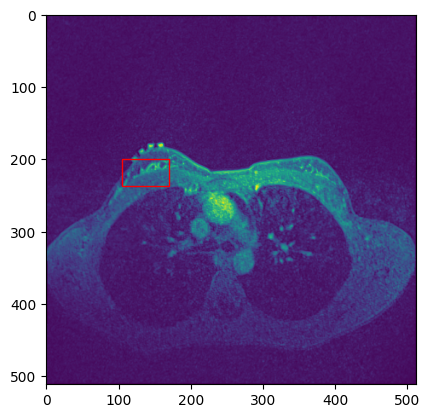

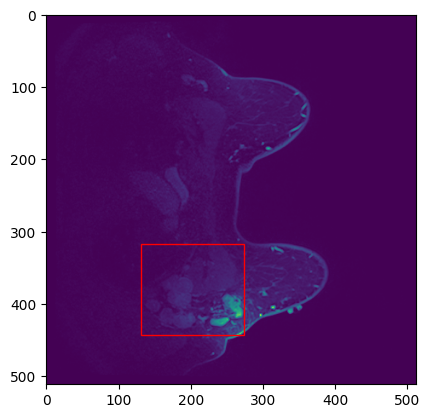

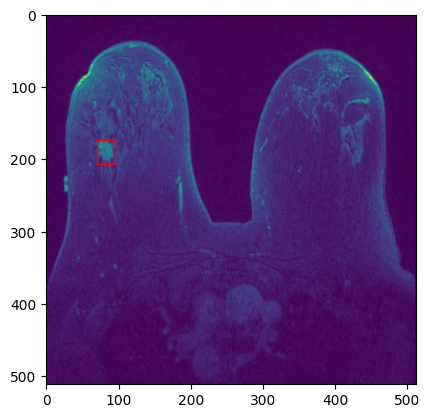

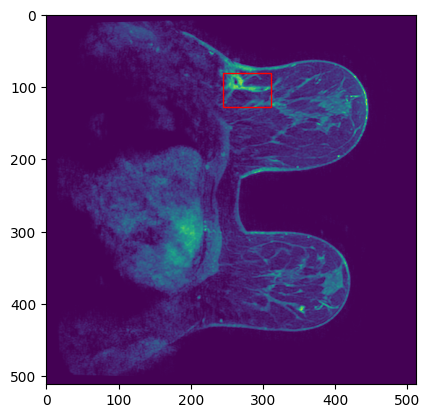

In [3]:
print(f"Number of training images: {len(train)}")

# function to visualize a single sample
def visualize_sample(image, target):
    box = target["boxes"][0]
    xy = (box[0], box[1])
    w = box[2] - box[0]
    h = box[3] - box[1]
    rect = Rectangle(xy, w, h, linewidth=1, edgecolor="r", facecolor="none")
    _, ax = plt.subplots(1)
    ax.imshow(image)
    ax.add_patch(rect)
    plt.show()

NUM_SAMPLES_TO_VISUALIZE = 5
TRANSFORMS = 3
for i in range(NUM_SAMPLES_TO_VISUALIZE):
        image, target = train[i]
        visualize_sample(image, target)

In [2]:
image, target = train[0]